# Epileptic Seizure Recognition (EEG Data)

The [dataset](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition#) chosen for this project consists of 500 files, each for a different subject. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points.

Every 4097 data points were divided and shuffled into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. Therefore, the data size is 23 x 500 = 11500 EEG samples (rows) by 178 data points for 1 second (columns). The last column (179) represents the label y (1,2,3,4,5).

In this project, we test four models (CNN, LSTM, CNN-LSTM, and TCN) to perform both multi-class classification and binary classification. The data source mentions that "although there are 5 classes, most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest." Although we focus our efforts on binary classification, we chose to also include multi-class classification to better understand the nature of the dataset.

Multi-class classification is used to identify relationships between classes, as well as to determine which model is best fit for this dataset. Then, the best performing model is used to classify between epileptic and non-epileptic brain activity in two forms: balanced-binary classification and inter-class binary classification. 
The motivations behind each method are explained further in their respective sections.


# Imports

In [ ]:
# import

import sys
import os
import numpy as np
import random
from tqdm import tqdm
import keras
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch.optim import Adam, SGD

import tensorflow as tf
from keras.layers import Input, LSTM, Add, MaxPooling1D
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Model
from tensorflow import keras, convert_to_tensor, experimental
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# mount to google drive

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# navigate to file path where data is located
%cd '/gdrive/My Drive/Fall 2021/BMEN 4470/Final Project'
data = pd.read_csv('./data.csv', header= None) # load data

/gdrive/My Drive/Fall 2021/BMEN 4470/Final Project


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def evaluate_model(history,X_test_T,y_test_T,model):
    scores = model.evaluate((X_test_T),y_test_T, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("Loss: %.2f%%" % (scores[0]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1']
    
    y_true=[]
    for element in y_test_T:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test_T)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

# Multi-Class Classification: All Models

For multi-class classification, we attempt to classify the 5 classes in the dataset:

>5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

>4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

>3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

>2 - They recorder the EEG from the area where the tumor was located

>1 - Recording of seizure activity

Note: The dataset source mentions that although the data is divided into five classes, most authors perform binary classification (classes 2,3,4 get combined into class 0-- non-epileptic activity). 

Here, we explore multi-class classification for each of four models (CNN, LSTM, CNN-LSTM, TCN) and choose the best model. The best model is then tested on binary classification.

### Data Preprocessing

In [ ]:
# We visualize the dataset
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,NaN,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
1,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
2,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
3,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
4,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5


In [ ]:
# Transform the dataset into a numpy array 

data=data.to_numpy()

# We split dataset in features (X) and labels (Y)

X = data[1:,1:179]
Y = data[1:,-1]

for i in range(0, len(Y)):
    Y[i] = int(Y[i])
print(X.shape,Y.shape)

(11500, 178) (11500,)


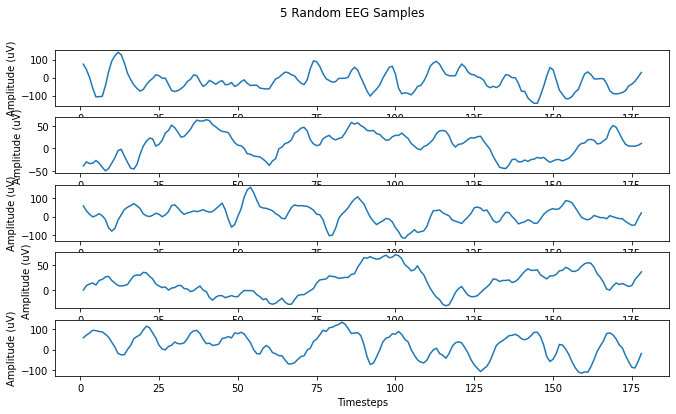

[10223.  8824.  9721.  8537.  8571.]
4
5
5
3
3


In [ ]:
# Visualize the data

t = np.arange(1,179)
fig = plt.figure(figsize=(11,6))
fig.suptitle('5 Random EEG Samples')

random_rows = np.round(np.random.uniform(0,11500,5))

c=1 # initialize count
for i in range(5):
	plt.subplot(5, 1, c)
	plt.plot(t,X[int(random_rows[i]),:])
	plt.xlabel('Timesteps')
	plt.ylabel('Amplitude (uV)')
	c = c + 1
plt.show()

# Print which rows are being plotted and their labels
print(random_rows)
for r in range(5):
  print( Y[int(random_rows[r])] )

In [ ]:
print(np.random.uniform(0,11501,5))

[6656.33769441  285.18865993 6790.68386492  970.30649382 2791.58793096]


In [ ]:
# Duplicate Y for multi-class classification
Y_multi = Y

In [ ]:
np.count_nonzero(Y_multi)

11500

In [ ]:
len(Y_multi)

11500

In [ ]:
# We split data into train(80%), test (10%) and validation (10%) set

# MULTI-CLASS CLASSIFICATION (Y_multi)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, Y_multi, test_size=0.1,random_state=1)
X_train_multi, X_val_multi, y_train_multi, y_val_multi = train_test_split(X_train_multi, y_train_multi, test_size=0.1,random_state=1)

print('Multi-Class Classification')
print(X_train_multi.shape, X_val_multi.shape,X_test_multi.shape)
print(y_train_multi.shape, y_val_multi.shape, y_test_multi.shape,'\n')

Multi-Class Classification
(9315, 178) (1035, 178) (1150, 178)
(9315,) (1035,) (1150,) 



In [ ]:
# Correct class labels for use with Python packages

y_train_multi[y_train_multi == 1] = 0
y_train_multi[y_train_multi == 2] = 1
y_train_multi[y_train_multi == 3] = 2
y_train_multi[y_train_multi == 4] = 3
y_train_multi[y_train_multi == 5] = 4

y_val_multi[y_val_multi == 1] = 0
y_val_multi[y_val_multi == 2] = 1
y_val_multi[y_val_multi == 3] = 2
y_val_multi[y_val_multi == 4] = 3
y_val_multi[y_val_multi == 5] = 4

y_test_multi[y_test_multi == 1] = 0
y_test_multi[y_test_multi == 2] = 1
y_test_multi[y_test_multi == 3] = 2
y_test_multi[y_test_multi == 4] = 3
y_test_multi[y_test_multi == 5] = 4

In [ ]:
# We convert data to tensor to use it in Keras API

X_train_multi = convert_to_tensor(X_train_multi, dtype=np.float32)
y_train_multi = convert_to_tensor(y_train_multi,dtype=np.float32)
X_test_multi = convert_to_tensor(X_test_multi,dtype=np.float32)
y_test_multi = convert_to_tensor(y_test_multi,dtype=np.float32)
X_val_multi = convert_to_tensor(X_val_multi,dtype=np.float32)
y_val_multi = convert_to_tensor(y_val_multi,dtype=np.float32)


### Model Evaluations

##### CNN


In [ ]:
# define model

im_shape=(X_train_multi.shape[1],1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
 

conv1d_1 = Convolution1D(filters=64, kernel_size=6, activation='relu',padding='valid')(inputs_cnn)
batch_normalization = BatchNormalization()(conv1d_1) 
max_pooling1d = MaxPool1D(pool_size=92,strides=1, padding='valid')(batch_normalization)
conv1d_2 = Convolution1D(filters=128, kernel_size=3, activation='relu',padding='valid')(max_pooling1d)
batch_normalization_1 = BatchNormalization()(conv1d_2) 
max_pooling1d_1 = MaxPool1D(pool_size=45,strides=1, padding='valid')(batch_normalization_1)
flatten = Flatten()(max_pooling1d_1)
dense = Dense(64, activation='relu')(flatten)
dense_1 = Dense(32, activation='relu')(dense)
main_output = Dense(5, activation='softmax')(dense_1) #output probabilities for 5 classes

    
model = Model(inputs= inputs_cnn, outputs=main_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])


In [ ]:
# print model summary
model_cnn = model
print(model_cnn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 178, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 173, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 173, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 82, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 128)           24704     
                                                                 
 batch_normalization_1 (Batc  (None, 80, 128)          512   

In [ ]:
# train the model
history = model_cnn.fit(X_train_multi, y_train_multi,epochs=50, batch_size=64,validation_data=(X_val_multi,y_val_multi))

Epoch 1/50
146/146 [==============================] - 16s 19ms/step - loss: 0.9021 - accuracy: 0.6131 - val_loss: 0.9332 - val_accuracy: 0.6097
Epoch 2/50
146/146 [==============================] - 2s 14ms/step - loss: 0.7987 - accuracy: 0.6426 - val_loss: 0.7559 - val_accuracy: 0.6464
Epoch 3/50
146/146 [==============================] - 2s 14ms/step - loss: 0.7383 - accuracy: 0.6625 - val_loss: 0.7788 - val_accuracy: 0.6425
Epoch 4/50
146/146 [==============================] - 2s 14ms/step - loss: 0.7196 - accuracy: 0.6747 - val_loss: 0.6692 - val_accuracy: 0.6850
Epoch 5/50
146/146 [==============================] - 2s 15ms/step - loss: 0.6922 - accuracy: 0.6853 - val_loss: 0.8131 - val_accuracy: 0.6087
Epoch 6/50
146/146 [==============================] - 2s 14ms/step - loss: 0.6773 - accuracy: 0.6990 - val_loss: 0.7836 - val_accuracy: 0.6300
Epoch 7/50
146/146 [==============================] - 2s 14ms/step - loss: 0.6506 - accuracy: 0.7067 - val_loss: 0.6464 - val_accuracy: 0.715

Accuracy: 73.13%
Loss: 60.72%


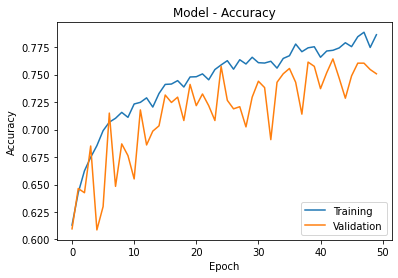

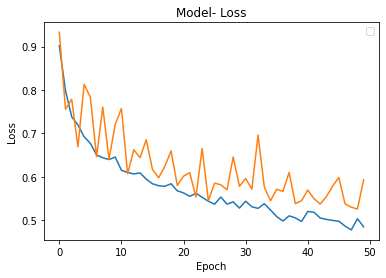

In [ ]:
# print result and plot accuracy and loss
evaluate_model(history,X_test_multi,y_test_multi,model_cnn)
y_pred_cnn=model_cnn.predict(X_test_multi)

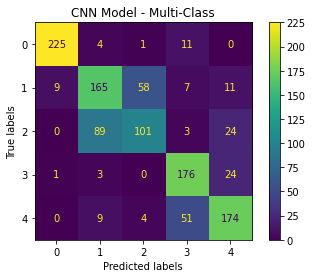

In [ ]:
# the predicted label is the label with the highest probability
y_pred_cnn = np.argmax(y_pred_cnn,axis=1)

CM_cnn_multi = confusion_matrix(y_test_multi, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_multi) 
disp.plot()
plt.title('CNN Model - Multi-Class')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

##### LSTM

In [ ]:
im_shape=(X_train_multi.shape[1],1)
inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')
    
dense = Dense(32, activation='relu')(inputs_lstm)
lstm = LSTM(128)(dense)
dropout = Dropout(0.3)(lstm)
batch_normalization = BatchNormalization()(dropout) 
dense_1 = Dense(64, activation='relu')(batch_normalization)
dropout_1 = Dropout(0.3)(dense_1)
batch_normalization_1 = BatchNormalization()(dropout_1)
main_output = Dense(5, activation='softmax')(batch_normalization_1)

model = Model(inputs= inputs_lstm, outputs=main_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model_lstm = model

In [ ]:
history = model_lstm.fit(X_train_multi,y_train_multi,epochs=50, batch_size=64,validation_data=(X_val_multi,y_val_multi))

Epoch 1/50
146/146 [==============================] - 15s 66ms/step - loss: 1.4814 - accuracy: 0.3968 - val_loss: 1.1619 - val_accuracy: 0.4860
Epoch 2/50
146/146 [==============================] - 9s 63ms/step - loss: 1.0788 - accuracy: 0.5300 - val_loss: 1.0643 - val_accuracy: 0.5662
Epoch 3/50
146/146 [==============================] - 9s 62ms/step - loss: 0.9855 - accuracy: 0.5626 - val_loss: 0.8230 - val_accuracy: 0.6280
Epoch 4/50
146/146 [==============================] - 9s 61ms/step - loss: 1.0437 - accuracy: 0.5410 - val_loss: 0.9726 - val_accuracy: 0.5411
Epoch 5/50
146/146 [==============================] - 9s 63ms/step - loss: 0.9220 - accuracy: 0.5855 - val_loss: 0.7321 - val_accuracy: 0.6396
Epoch 6/50
146/146 [==============================] - 9s 61ms/step - loss: 0.8416 - accuracy: 0.6196 - val_loss: 0.7400 - val_accuracy: 0.6580
Epoch 7/50
146/146 [==============================] - 9s 62ms/step - loss: 0.7726 - accuracy: 0.6459 - val_loss: 0.8103 - val_accuracy: 0.622

Accuracy: 72.78%
Loss: 63.49%


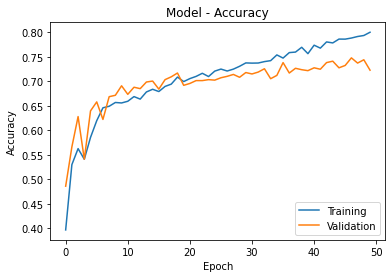

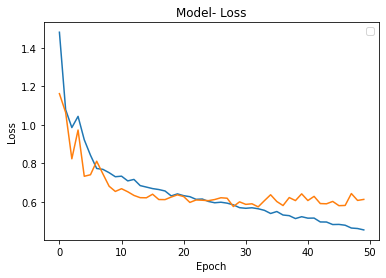

In [ ]:
evaluate_model(history,X_test_multi,y_test_multi,model_lstm)
y_pred_lstm=model_lstm.predict(X_test_multi)

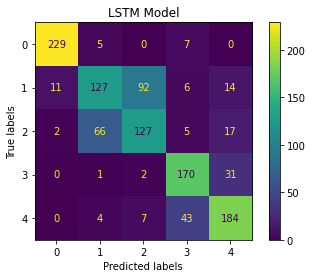

In [ ]:
# confusion matrix
y_pred_lstm = np.argmax(y_pred_lstm,axis=1)

CM_lstm = confusion_matrix(y_test_multi, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_lstm) 
disp.plot()
plt.title('LSTM Model')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

##### CNN-LSTM

In [ ]:
im_shape=(X_train_multi.shape[1],1)
inputs_cnn_lstm=Input(shape=(im_shape), name='inputs_cnn_lstm')


conv1d_1 = Convolution1D(filters=64, kernel_size=6, activation='relu',padding='valid')(inputs_cnn_lstm)
batch_normalization = BatchNormalization()(conv1d_1) 
max_pooling1d = MaxPool1D(pool_size=92,strides=1, padding='valid')(batch_normalization)
    
conv1d_2 = Convolution1D(filters=128, kernel_size=3, activation='relu',padding='valid')(max_pooling1d)
batch_normalization_1 = BatchNormalization()(conv1d_2) 
max_pooling1d_1 = MaxPool1D(pool_size=45,strides=1, padding='valid')(batch_normalization_1)
    
lstm = LSTM(128)(max_pooling1d_1)

flatten = Flatten()(lstm)
dense = Dense(64, activation='relu')(flatten)
dense_1 = Dense(32, activation='relu')(dense)
main_output = Dense(5, activation='softmax')(dense_1)
  
model = Model(inputs=inputs_cnn_lstm, outputs=main_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model_cnn_lstm = model

In [ ]:
history=model_cnn_lstm.fit(X_train_multi,y_train_multi,epochs=50, batch_size=64,validation_data=(X_val_multi,y_val_multi))

Epoch 1/50
146/146 [==============================] - 7s 27ms/step - loss: 0.8779 - accuracy: 0.6056 - val_loss: 0.8160 - val_accuracy: 0.6193
Epoch 2/50
146/146 [==============================] - 3s 22ms/step - loss: 0.7604 - accuracy: 0.6498 - val_loss: 0.7519 - val_accuracy: 0.6580
Epoch 3/50
146/146 [==============================] - 3s 22ms/step - loss: 0.7364 - accuracy: 0.6656 - val_loss: 0.7485 - val_accuracy: 0.6522
Epoch 4/50
146/146 [==============================] - 3s 22ms/step - loss: 0.7040 - accuracy: 0.6747 - val_loss: 0.7334 - val_accuracy: 0.6512
Epoch 5/50
146/146 [==============================] - 3s 22ms/step - loss: 0.6853 - accuracy: 0.6864 - val_loss: 0.7156 - val_accuracy: 0.6502
Epoch 6/50
146/146 [==============================] - 3s 21ms/step - loss: 0.6905 - accuracy: 0.6887 - val_loss: 0.7144 - val_accuracy: 0.6657
Epoch 7/50
146/146 [==============================] - 3s 21ms/step - loss: 0.6440 - accuracy: 0.7045 - val_loss: 0.7331 - val_accuracy: 0.6560

Accuracy: 75.57%
Loss: 55.36%


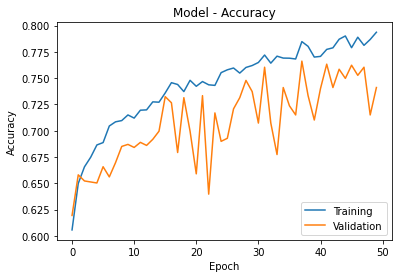

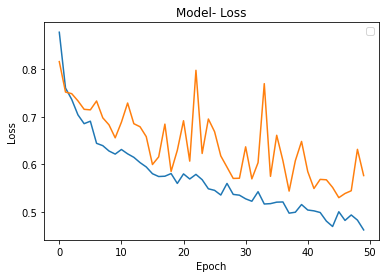

In [ ]:
evaluate_model(history,X_test_multi,y_test_multi,model_cnn_lstm)
y_pred_cnn_lstm=model_cnn_lstm.predict(X_test_multi)

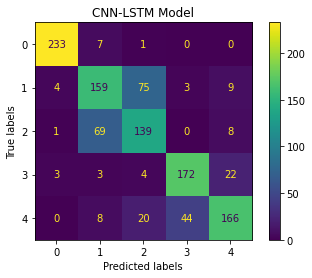

In [ ]:
# confusion matrix
y_pred_cnn_lstm = np.argmax(y_pred_cnn_lstm,axis=1)

CM_cnn_lstm = confusion_matrix(y_test_multi, y_pred_cnn_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm) 
disp.plot()
plt.title('CNN-LSTM Model')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

##### TCN


In [ ]:
# ResNet based Temporal Convolutional Network (TCN) with dilation and skip connections

def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """
  shortcut = data

  #dilation
  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Convolution1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Convolution1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])


  return x
  

In [ ]:
# Define TCN

#input
x_input = Input(shape=(X_train_multi.shape[1], 1))

#initial conv
conv = Convolution1D(X_train_multi.shape[1], 3, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, X_train_multi.shape[1], 2)
res2 = residual_block(res1, X_train_multi.shape[1], 3)

#Max Pooling
x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

#softmax classifier
x = Flatten()(x)
x_output = Dense(5, activation='softmax', kernel_regularizer=l2(0.0001))(x)

#Compile the model
model_tcn = Model(inputs=x_input, outputs=x_output)
model_tcn.compile(optimizer='adam', 
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])


In [ ]:
# Early Stopping
# es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history_tcn = model_tcn.fit(
    X_train_multi, y_train_multi,
    epochs=50, batch_size=64,
    validation_data=(X_val_multi, y_val_multi),)
    # callbacks=[es])

Epoch 1/50
146/146 [==============================] - 10s 50ms/step - loss: 7.7445 - accuracy: 0.4856 - val_loss: 2.9508 - val_accuracy: 0.5739
Epoch 2/50
146/146 [==============================] - 6s 42ms/step - loss: 2.5139 - accuracy: 0.5702 - val_loss: 2.6426 - val_accuracy: 0.5014
Epoch 3/50
146/146 [==============================] - 6s 41ms/step - loss: 1.8866 - accuracy: 0.6068 - val_loss: 1.6029 - val_accuracy: 0.6425
Epoch 4/50
146/146 [==============================] - 6s 41ms/step - loss: 1.7506 - accuracy: 0.6239 - val_loss: 1.4672 - val_accuracy: 0.6570
Epoch 5/50
146/146 [==============================] - 6s 41ms/step - loss: 1.5837 - accuracy: 0.6524 - val_loss: 1.5646 - val_accuracy: 0.6087
Epoch 6/50
146/146 [==============================] - 6s 41ms/step - loss: 1.5903 - accuracy: 0.6467 - val_loss: 1.3636 - val_accuracy: 0.6715
Epoch 7/50
146/146 [==============================] - 6s 42ms/step - loss: 1.4252 - accuracy: 0.6675 - val_loss: 1.3285 - val_accuracy: 0.670

Accuracy: 71.74%
Loss: 126.08%


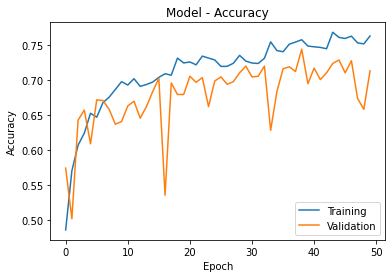

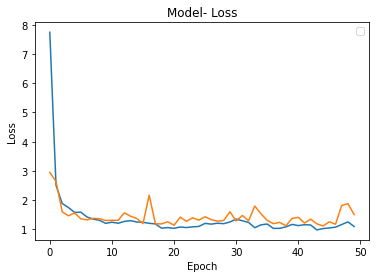

In [ ]:
# Plot loss and accuracy, then evaluate model
evaluate_model(history_tcn,X_test_multi,y_test_multi,model_tcn)

# Evaluate the model
y_pred_tcn = model_tcn.predict(X_test_multi)
y_pred_tcn = np.argmax(y_pred_tcn,axis=1)

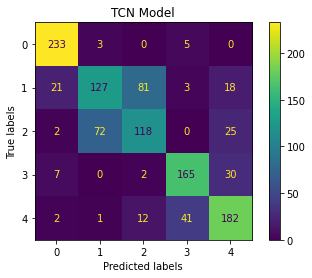

In [ ]:
# Display confusion matrix
CM_tcn = confusion_matrix(y_test_multi, y_pred_tcn)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_tcn) 
disp.plot()
plt.title('TCN Model')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

### Compare CNN, LSTM, CNN-LSTM, and TCN


Results for CNN:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       241
         1.0       0.61      0.66      0.63       250
         2.0       0.62      0.47      0.53       217
         3.0       0.71      0.86      0.78       204
         4.0       0.75      0.73      0.74       238

    accuracy                           0.73      1150
   macro avg       0.73      0.73      0.73      1150
weighted avg       0.73      0.73      0.73      1150

Results for LSTM:
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       241
         1.0       0.63      0.51      0.56       250
         2.0       0.56      0.59      0.57       217
         3.0       0.74      0.83      0.78       204
         4.0       0.75      0.77      0.76       238

    accuracy                           0.73      1150
   macro avg       0.72      0.73      0.72      1150
weighted avg       0.72      0.73      0

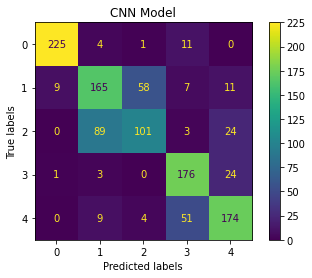

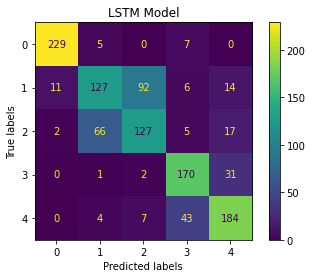

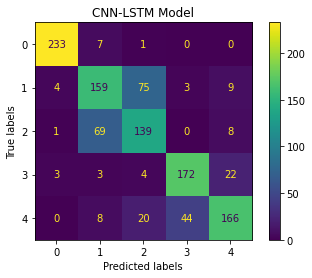

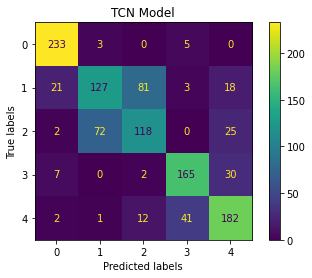

In [ ]:
# Confusion matrices of each model
CM_cnn = confusion_matrix(y_test_multi, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn) 
disp.plot()
plt.title('CNN Model')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

CM_lstm = confusion_matrix(y_test_multi, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_lstm) 
disp.plot()
plt.title('LSTM Model')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

CM_cnn_lstm = confusion_matrix(y_test_multi, y_pred_cnn_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm) 
disp.plot()
plt.title('CNN-LSTM Model')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

CM_tcn = confusion_matrix(y_test_multi, y_pred_tcn)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_tcn) 
disp.plot()
plt.title('TCN Model')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

# Final classification report
print('Results for CNN:\n',classification_report(y_test_multi, y_pred_cnn))
print('Results for LSTM:\n',classification_report(y_test_multi, y_pred_lstm))
print('Results for CNN-LSTM:\n',classification_report(y_test_multi, y_pred_cnn_lstm))
print('Results for TCN:\n',classification_report(y_test_multi, y_pred_tcn))

### Multi-Class Summary 

From evaluation of the loss plots, classification reports, and confusion matrices, we can clearly see that the CNN-LSTM model achieves the best multi-class classification accuracy at approximately 75%. The CNN-LSTM model's success is supported by its special architecture, designed to capture both spatial structure and temporal structure. Although this dataset is provided as single-channel EEG, it is inherently composed of spatiotemporal data. This is belief is supported by evaluation of the multi-class confusion matrices.

From the confusion matrices, it is readily apparent that all four models had the easiest time classifying the epileptic activity of class 0. The second best classification is class 4, eyes open. However, all models had a difficult time distinguishing between classes 1 and 2. Even by description, class 1 and class 2 seem to be very similar and even a bit ambiguous. Class 1 data is stated to have been recorded at the "tumor" location (suspected to mean epileptogenic zone) during non-epileptic activity while class 2 data was also non-epileptic activity, but recorded from healthy tissue.

As this is single-channel EEG data, it is possible that class 1 and 2 are not easily distinguishable because they contain resting-state EEG from locations that are spatially close to each other. It may be the case that class 1 and 2 are not from different trials, but rather from different electrodes. If so, resting-state EEG may not be significantly different enough for any classifier to classify between two nearby electrodes, especially if both electrodes contain non-epileptic activity.

Next, the best model (CNN-LSTM) will be tested on binary classification.

# Binary Classification: Best Model (CNN-LSTM)

For binary classification, we will try two different methods:

1) Because the differences between the non-epileptic classes might be subtle, we will compare the epileptic class vs. each of the non-epileptic classes separately. Classification accuracies for class 1v2, 1v3, 1v4, and 1v5 are reported in histogram form.

We call this **Inter-Class Binary Classification**.

2) Because the non-epileptic activity has many more samples (classes 2, 3, 4 turned into class 0) than the epileptic activity, we want to create a random sampling from class 0 that is equal in size to class 1. To determine the consistency of this method, we will repeat training with different random samplings of the non-epilectic class in order to perform a ten-fold cross validation.

We call this **Balanced Binary Classification**.

### Inter-Class Binary Classification


#### Data Preprocessing

In [ ]:
# re-import the data
data = pd.read_csv('./data.csv', header= None) # load data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# We visualize the dataset
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,NaN,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
1,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
2,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
3,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
4,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5


Create Datasets for 1v2, 1v3, 1v4, 1v5

In [ ]:
# data_i is the label column for class 1 vs class i for i in [2,5]
# used for interclass binary accuracies

data_2 = data.loc[data[179].isin([1,2])]
data_3 = data.loc[data[179].isin([1,3])]
data_4 = data.loc[data[179].isin([1,4])]
data_5 = data.loc[data[179].isin([1,5])]

In [ ]:
#Then we transform the dataset into a numpy array 

data_2=data_2.to_numpy()
data_3=data_3.to_numpy()
data_4=data_4.to_numpy()
data_5=data_5.to_numpy()

#We split dataset in features (X) and labels (Y)

X_2 = data_2[1:,1:179]
Y_2 = data_2[1:,-1]

for i in range(0, len(Y_2)):
    Y_2[i] = int(Y_2[i])
print(X_2.shape,Y_2.shape)

X_3 = data_3[1:,1:179]
Y_3 = data_3[1:,-1]

for i in range(0, len(Y_3)):
    Y_3[i] = int(Y_3[i])
print(X_3.shape,Y_3.shape)

X_4 = data_4[1:,1:179]
Y_4 = data_4[1:,-1]

for i in range(0, len(Y_4)):
    Y_4[i] = int(Y_4[i])
print(X_4.shape,Y_4.shape)

X_5 = data_5[1:,1:179]
Y_5 = data_5[1:,-1]

for i in range(0, len(Y_5)):
    Y_5[i] = int(Y_5[i])
print(X_5.shape,Y_5.shape)

(2984, 178) (2984,)
(2949, 178) (2949,)
(2937, 178) (2937,)
(2995, 178) (2995,)


In [ ]:
#We set the classes 2,3,4 & 5 to 0 for the binary classification because they all represent non epileptic patient
  
Y_2 = np.where(Y_2>1,0,Y_2)
Y_3 = np.where(Y_3>1,0,Y_3)
Y_4 = np.where(Y_4>1,0,Y_4)
Y_5 = np.where(Y_5>1,0,Y_5)

In [ ]:
from sklearn.model_selection import train_test_split

# BINARY CLASSIFICATION (Y)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.1,random_state=1)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_2, y_train_2, test_size=0.1,random_state=1)


X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, Y_3, test_size=0.1,random_state=1)
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_train_3, y_train_3, test_size=0.1,random_state=1)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, Y_4, test_size=0.1,random_state=1)
X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(X_train_4, y_train_4, test_size=0.1,random_state=1)


X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, Y_5, test_size=0.1,random_state=1)
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(X_train_5, y_train_5, test_size=0.1,random_state=1)


In [ ]:
print('Interclass Binary Classification')
print(X_train_2.shape, X_val_2.shape,X_test_2.shape)
print(y_train_2.shape, y_val_2.shape, y_test_2.shape,'\n')

print(X_train_3.shape, X_val_3.shape,X_test_3.shape)
print(y_train_3.shape, y_val_3.shape, y_test_3.shape,'\n')

print(X_train_4.shape, X_val_4.shape,X_test_4.shape)
print(y_train_4.shape, y_val_4.shape, y_test_4.shape,'\n')

print(X_train_5.shape, X_val_5.shape,X_test_5.shape)
print(y_train_5.shape, y_val_5.shape, y_test_5.shape,'\n')

Interclass Binary Classification
(2416, 178) (269, 178) (299, 178)
(2416,) (269,) (299,) 

(2388, 178) (266, 178) (295, 178)
(2388,) (266,) (295,) 

(2378, 178) (265, 178) (294, 178)
(2378,) (265,) (294,) 

(2425, 178) (270, 178) (300, 178)
(2425,) (270,) (300,) 



In [ ]:
#We convert data to tensor to use it in Keras API

# Binary
X_train_2 = convert_to_tensor(X_train_2, dtype=np.float32)
y_train_2 = convert_to_tensor(y_train_2,dtype=np.float32)
X_test_2 = convert_to_tensor(X_test_2,dtype=np.float32)
y_test_2 = convert_to_tensor(y_test_2,dtype=np.float32)
X_val_2 = convert_to_tensor(X_val_2,dtype=np.float32)
y_val_2 = convert_to_tensor(y_val_2,dtype=np.float32)

X_train_3 = convert_to_tensor(X_train_3, dtype=np.float32)
y_train_3 = convert_to_tensor(y_train_3,dtype=np.float32)
X_test_3 = convert_to_tensor(X_test_3,dtype=np.float32)
y_test_3 = convert_to_tensor(y_test_3,dtype=np.float32)
X_val_3 = convert_to_tensor(X_val_3,dtype=np.float32)
y_val_3 = convert_to_tensor(y_val_3,dtype=np.float32)

X_train_4 = convert_to_tensor(X_train_4, dtype=np.float32)
y_train_4 = convert_to_tensor(y_train_4,dtype=np.float32)
X_test_4 = convert_to_tensor(X_test_4,dtype=np.float32)
y_test_4 = convert_to_tensor(y_test_4,dtype=np.float32)
X_val_4 = convert_to_tensor(X_val_4,dtype=np.float32)
y_val_4 = convert_to_tensor(y_val_4,dtype=np.float32)

X_train_5 = convert_to_tensor(X_train_5, dtype=np.float32)
y_train_5 = convert_to_tensor(y_train_5,dtype=np.float32)
X_test_5 = convert_to_tensor(X_test_5,dtype=np.float32)
y_test_5 = convert_to_tensor(y_test_5,dtype=np.float32)
X_val_5 = convert_to_tensor(X_val_5,dtype=np.float32)
y_val_5 = convert_to_tensor(y_val_5,dtype=np.float32)

#### Model Evaluation

##### Model: change im_shape for each run accordingly (2, 3, 4, 5)

In [ ]:
im_shape=(X_train_5.shape[1],1)
inputs_cnn_lstm=Input(shape=(im_shape), name='inputs_cnn_lstm')


conv1d_1 = Convolution1D(filters=64, kernel_size=6, activation='relu',padding='valid')(inputs_cnn_lstm)
batch_normalization = BatchNormalization()(conv1d_1) 
max_pooling1d = MaxPool1D(pool_size=92,strides=1, padding='valid')(batch_normalization)
    
conv1d_2 = Convolution1D(filters=128, kernel_size=3, activation='relu',padding='valid')(max_pooling1d)
batch_normalization_1 = BatchNormalization()(conv1d_2) 
max_pooling1d_1 = MaxPool1D(pool_size=45,strides=1, padding='valid')(batch_normalization_1)
    
lstm = LSTM(128)(max_pooling1d_1)

flatten = Flatten()(lstm)
dense = Dense(64, activation='relu')(flatten)
dense_1 = Dense(32, activation='relu')(dense)
main_output = Dense(2, activation='softmax')(dense_1)
  
model = Model(inputs=inputs_cnn_lstm, outputs=main_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model_cnn_lstm = model
print(model_cnn_lstm.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn_lstm (InputLayer  [(None, 178, 1)]         0         
 )                                                               
                                                                 
 conv1d_15 (Conv1D)          (None, 173, 64)           448       
                                                                 
 batch_normalization_16 (Bat  (None, 173, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 82, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 80, 128)           24704     
                                                           

##### Class 1 v 2

In [ ]:
history=model_cnn_lstm.fit(X_train_2,y_train_2,epochs=10, batch_size=64,validation_data=(X_val_2,y_val_2))

Epoch 1/10
38/38 [==============================] - 4s 43ms/step - loss: 0.2044 - accuracy: 0.9226 - val_loss: 0.6156 - val_accuracy: 0.7695
Epoch 2/10
38/38 [==============================] - 1s 23ms/step - loss: 0.1440 - accuracy: 0.9478 - val_loss: 0.2266 - val_accuracy: 0.9294
Epoch 3/10
38/38 [==============================] - 1s 23ms/step - loss: 0.1360 - accuracy: 0.9524 - val_loss: 0.1530 - val_accuracy: 0.9517
Epoch 4/10
38/38 [==============================] - 1s 22ms/step - loss: 0.1315 - accuracy: 0.9528 - val_loss: 0.1691 - val_accuracy: 0.9331
Epoch 5/10
38/38 [==============================] - 1s 22ms/step - loss: 0.1349 - accuracy: 0.9458 - val_loss: 0.1565 - val_accuracy: 0.9368
Epoch 6/10
38/38 [==============================] - 1s 23ms/step - loss: 0.1405 - accuracy: 0.9503 - val_loss: 0.2107 - val_accuracy: 0.9033
Epoch 7/10
38/38 [==============================] - 1s 22ms/step - loss: 0.1194 - accuracy: 0.9541 - val_loss: 0.1653 - val_accuracy: 0.9442
Epoch 8/10
38

Accuracy: 95.32%
Loss: 9.68%


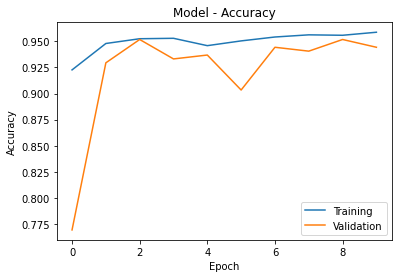

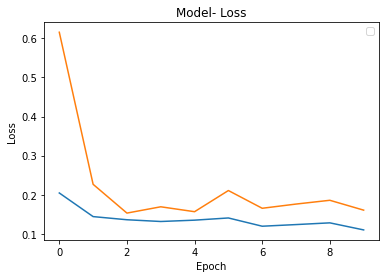

In [ ]:
evaluate_model(history,X_test_2,y_test_2,model_cnn_lstm)
y_pred_cnn_lstm_2=model_cnn_lstm.predict(X_test_2)

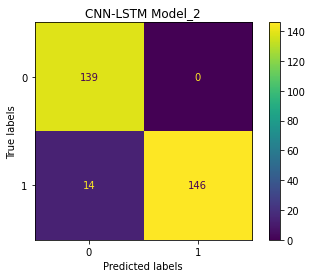

In [ ]:
# confusion matrix
y_pred_cnn_lstm_2 = np.argmax(y_pred_cnn_lstm_2,axis=1)

CM_cnn_lstm_2 = confusion_matrix(y_test_2, y_pred_cnn_lstm_2)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm_2) 
disp.plot()
plt.title('CNN-LSTM Model_2')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

In [ ]:
scores_2 = model_cnn_lstm.evaluate((X_test_2),y_test_2, verbose=0)
Acc2 = scores_2[1]
Acc2=round(Acc2,3)
print(Acc2)

0.903


##### Class 1 v 3

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])
history=model_cnn_lstm.fit(X_train_3,y_train_3,epochs=10, batch_size=64,validation_data=(X_val_3,y_val_3))

Epoch 1/10
38/38 [==============================] - 5s 40ms/step - loss: 0.0765 - accuracy: 0.9724 - val_loss: 0.0340 - val_accuracy: 0.9850
Epoch 2/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0677 - accuracy: 0.9786 - val_loss: 0.0540 - val_accuracy: 0.9774
Epoch 3/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0590 - accuracy: 0.9816 - val_loss: 0.0443 - val_accuracy: 0.9850
Epoch 4/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0560 - accuracy: 0.9820 - val_loss: 0.0493 - val_accuracy: 0.9850
Epoch 5/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0589 - accuracy: 0.9820 - val_loss: 0.0572 - val_accuracy: 0.9699
Epoch 6/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0431 - accuracy: 0.9858 - val_loss: 0.0459 - val_accuracy: 0.9850
Epoch 7/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0474 - accuracy: 0.9870 - val_loss: 0.0620 - val_accuracy: 0.9737
Epoch 8/10
38

Accuracy: 97.29%
Loss: 9.56%


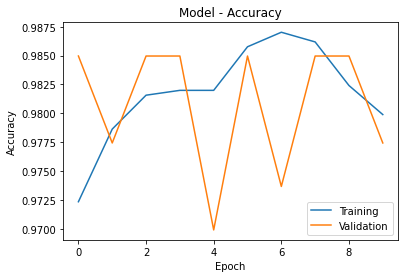

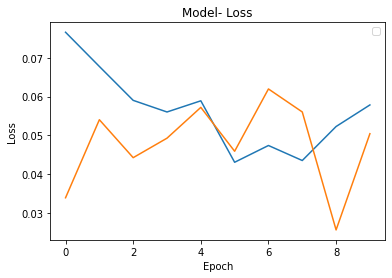

In [ ]:
evaluate_model(history,X_test_3,y_test_3,model_cnn_lstm)
y_pred_cnn_lstm_3=model_cnn_lstm.predict(X_test_3)

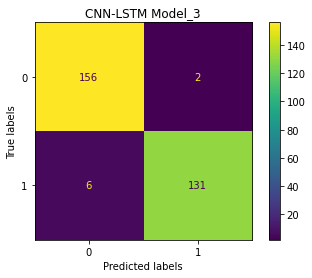

In [ ]:
# confusion matrix
y_pred_cnn_lstm_3 = np.argmax(y_pred_cnn_lstm_3,axis=1)

CM_cnn_lstm_3 = confusion_matrix(y_test_3, y_pred_cnn_lstm_3)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm_3) 
disp.plot()
plt.title('CNN-LSTM Model_3')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

In [ ]:
scores_3 = model_cnn_lstm.evaluate((X_test_3),y_test_3, verbose=0)
Acc3 = scores_3[1]
Acc3=round(Acc3,3)
print(Acc3)

0.915


##### Class 1 v 4

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])
history=model_cnn_lstm.fit(X_train_4,y_train_4,epochs=10, batch_size=64,validation_data=(X_val_4,y_val_4))

Epoch 1/10
38/38 [==============================] - 4s 38ms/step - loss: 0.1208 - accuracy: 0.9613 - val_loss: 0.1659 - val_accuracy: 0.9245
Epoch 2/10
38/38 [==============================] - 1s 21ms/step - loss: 0.0644 - accuracy: 0.9769 - val_loss: 0.2023 - val_accuracy: 0.9132
Epoch 3/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0613 - accuracy: 0.9781 - val_loss: 0.1769 - val_accuracy: 0.9396
Epoch 4/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0579 - accuracy: 0.9811 - val_loss: 0.1577 - val_accuracy: 0.9396
Epoch 5/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0598 - accuracy: 0.9777 - val_loss: 0.2155 - val_accuracy: 0.9283
Epoch 6/10
38/38 [==============================] - 1s 21ms/step - loss: 0.0456 - accuracy: 0.9819 - val_loss: 0.2012 - val_accuracy: 0.9472
Epoch 7/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0443 - accuracy: 0.9857 - val_loss: 0.1284 - val_accuracy: 0.9585
Epoch 8/10
38

Accuracy: 97.96%
Loss: 7.76%


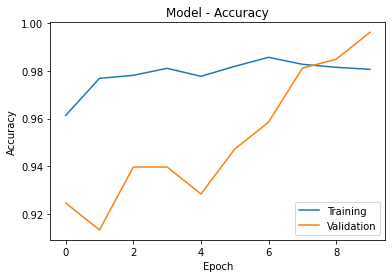

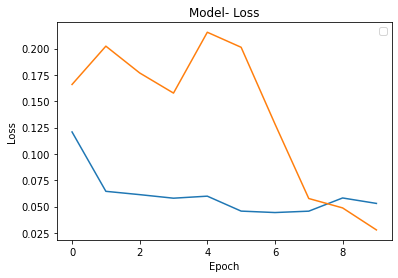

In [ ]:
evaluate_model(history,X_test_4,y_test_4,model_cnn_lstm)
y_pred_cnn_lstm_4=model_cnn_lstm.predict(X_test_4)

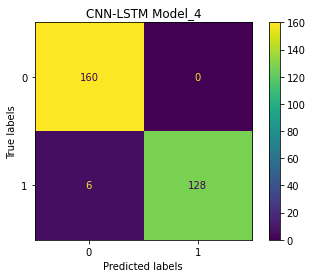

In [ ]:
# confusion matrix
y_pred_cnn_lstm_4 = np.argmax(y_pred_cnn_lstm_4,axis=1)

CM_cnn_lstm_4 = confusion_matrix(y_test_4, y_pred_cnn_lstm_4)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm_4) 
disp.plot()
plt.title('CNN-LSTM Model_4')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

In [ ]:
scores_4 = model_cnn_lstm.evaluate((X_test_4),y_test_4, verbose=0)
Acc4 = scores_4[1]
Acc4=round(Acc4,3)
print(Acc4)

0.874


##### Class 1 v 5

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])
history=model_cnn_lstm.fit(X_train_5,y_train_5,epochs=10, batch_size=64,validation_data=(X_val_5,y_val_5))

Epoch 1/10
38/38 [==============================] - 4s 39ms/step - loss: 0.0227 - accuracy: 0.9918 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0203 - accuracy: 0.9930 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0186 - accuracy: 0.9930 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0183 - accuracy: 0.9938 - val_loss: 0.0055 - val_accuracy: 0.9963
Epoch 5/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.0292 - val_accuracy: 0.9889
Epoch 7/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0178 - accuracy: 0.9926 - val_loss: 0.0146 - val_accuracy: 0.9889
Epoch 8/10
38

Accuracy: 98.67%
Loss: 3.11%


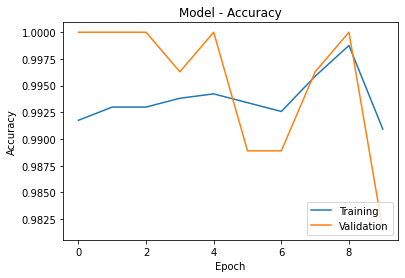

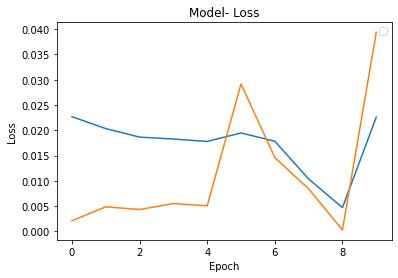

In [ ]:
evaluate_model(history,X_test_5,y_test_5,model_cnn_lstm)
y_pred_cnn_lstm_5=model_cnn_lstm.predict(X_test_5)

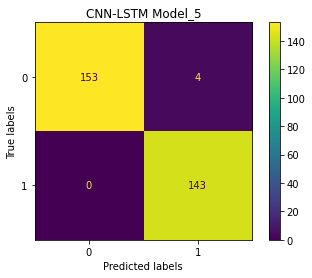

In [ ]:
# confusion matrix
y_pred_cnn_lstm_5 = np.argmax(y_pred_cnn_lstm_5,axis=1)

CM_cnn_lstm_5 = confusion_matrix(y_test_5, y_pred_cnn_lstm_5)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm_5) 
disp.plot()
plt.title('CNN-LSTM Model_5')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

In [ ]:
scores_5 = model_cnn_lstm.evaluate((X_test_5),y_test_5, verbose=0)
Acc5 = scores_5[1]
Acc5=round(Acc5,3)
print(Acc5)

0.987


##### Inter-Class Classification Summary

Performing inter-class classification allows us to confirm our observations from the multi-class classification. 


In particular, classes 2 and 3 (a.k.a. 1 and 2) compare almost identically to class 1, strengthening the notion that these classes are marginally dissimilar to each other due to suspected spatial proximity.

Furthermore, the accuracy in classification between class 1 and 4 (eyes closed) is notably the lowest. This could be explained by the presence of alpha waves during recordings when a subject's eyes are closed. Although the presence of a "different" signal would be expected to aid classification, it may instead act as a confound for finding nuanced differences against the epileptic class. The last class (eyes open) has the highest accuracy. This is because epilepsy is characterized by its hypersynchronous nature, which may appear similar to alpha waveforms in the feature space. On the other hand, the last class (eyes open) has the highest accuracy. Coupled with the result of the class 4, this may also indicate that the majority of subjects' eyes were closed during epileptic seizures, but this is a broader assumption.


(0.8, 1.0)

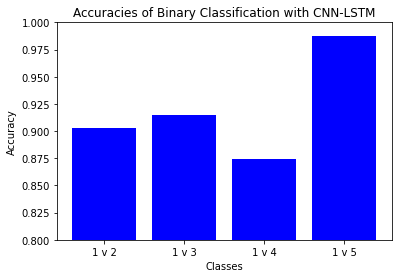

In [ ]:
# plot inter-class accuracies in a barplot

labels = ['1 v 2', '1 v 3', '1 v 4', '1 v 5']
accs = np.array([Acc2,Acc3,Acc4,Acc5])

plt.bar(x= labels ,height= accs, color = 'blue')

plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracies of Binary Classification with CNN-LSTM')

plt.ylim(0.8, 1)

### Balanced Binary Classification

#### Data Preprocessing

In [ ]:
# Using the already imported data

# We set the classes 2,3,4,5 to 0 for the binary classification because they all represent non epileptic patient  
Y = np.where(Y>1,0,Y)

print(np.count_nonzero(Y))
print(len(Y))

2300
11500


In [ ]:
# Repeat preprocessing steps from multi-class for binary

# Perform 80/10/10 Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=1)

# convert lists to numpy array
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train,dtype=np.float32)
X_test = np.asarray(X_test,dtype=np.float32)
y_test = np.asarray(y_test,dtype=np.float32)
X_val = np.asarray(X_val,dtype=np.float32)
y_val = np.asarray(y_val,dtype=np.float32)

print('Binary Classification')
print(X_train.shape, X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape,'\n')

Binary Classification
(9315, 178) (1035, 178) (1150, 178)
(9315,) (1035,) (1150,) 



In [ ]:
# Visualize split of data 
print('Total Sample Counts')
print('Data: ', X_train.shape, X_val.shape, X_test.shape) # data for all activity
print('Labels: ', y_train.shape, y_val.shape, y_test.shape, '\n' ) # labels for all activity

# define separate arrays for non-epilectic or epileptic activity (data & labels)
X_train_0 = X_train[y_train == 0]
X_val_0 = X_val[y_val == 0]
X_test_0 = X_test[y_test == 0]

X_train_1 = X_train[y_train == 1]
X_val_1 = X_val[y_val == 1]
X_test_1 = X_test[y_test == 1]

y_train_0 = y_train[y_train == 0]
y_val_0 = y_val[y_val == 0]
y_test_0 = y_test[y_test == 0]

y_train_1 = y_train[y_train == 1]
y_val_1 = y_val[y_val == 1]
y_test_1 = y_test[y_test == 1]

print('Non-Epileptic Activity')
print('Data: ', X_train_0.shape, X_val_0.shape, X_test_0.shape ) # labels for non-epileptic activity
print('Labels: ',y_train_0.shape, y_val_0.shape, y_test_0.shape, '\n' ) # labels for non-epileptic activity

print('Epileptic Activity')
print('Data: ',X_train_1.shape, X_val_1.shape, X_test_1.shape) # labels for epileptic activity
print('Labels: ', y_train_1.shape, y_val_1.shape, y_test_1.shape, '\n' ) # labels for epileptic activity

print('Goal Sizes: 2x each of the below, with an extra dimension for 10-fold cross-val')
print('Data: ', (X_train_1.shape), X_val_1.shape, X_test_1.shape) # labels for epileptic activity
print('Labels: ', y_train_1.shape, y_val_1.shape, y_test_1.shape ) # labels for epileptic activity


Total Sample Counts
Data:  (9315, 178) (1035, 178) (1150, 178)
Labels:  (9315,) (1035,) (1150,) 

Non-Epileptic Activity
Data:  (7470, 178) (821, 178) (909, 178)
Labels:  (7470,) (821,) (909,) 

Epileptic Activity
Data:  (1845, 178) (214, 178) (241, 178)
Labels:  (1845,) (214,) (241,) 

Goal Sizes: 2x each of the below, with an extra dimension for 10-fold cross-val
Data:  (1845, 178) (214, 178) (241, 178)
Labels:  (1845,) (214,) (241,)


In [ ]:
## Randomly sample non-epileptic data to match epileptic

# create lists of random indices
y_train_ids = random.sample(range(1, len(y_train_0)), len(y_train_1))
y_val_ids = random.sample(range(1, len(y_val_0)), len(y_val_1))
y_test_ids = random.sample(range(1, len(y_test_0)), len(y_test_1))

# create subset arrays for train, val, and test data/labels
X_train_sub = np.zeros_like(X_train_1); y_train_sub = np.zeros_like(y_train_1)
X_val_sub = np.zeros_like(X_val_1); y_val_sub = np.zeros_like(y_val_1)
X_test_sub = np.zeros_like(X_test_1); y_test_sub = np.zeros_like(y_test_1)

## Repeat 10 times for cross-validation

X_train_ten = np.zeros((10,3690,178)); y_train_ten = np.zeros((10,3690)); 
X_val_ten = np.zeros((10,428,178)); y_val_ten = np.zeros((10,428));
X_test_ten = np.zeros((10,482,178)); y_test_ten = np.zeros((10,482));

for t in range(10):
  # populate subset lists
  for i in range(len(y_train_1)):
    X_train_sub[i] = X_train_0[y_train_ids[i]]
    y_train_sub[i] = y_train_0[y_train_ids[i]]

  for i in range(len(y_val_1)):
    X_val_sub[i] = X_val_0[y_val_ids[i]]
    y_val_sub[i] = y_val_0[y_val_ids[i]]

  for i in range(len(y_test_1)):
    X_test_sub[i] = X_test_0[y_test_ids[i]]
    y_test_sub[i] = y_test_0[y_test_ids[i]]

  # non-epileptic and epileptic data/labels
  X_train = np.concatenate((X_train_sub,X_train_1),axis=0)
  X_val = np.concatenate((X_val_sub,X_val_1),axis=0)
  X_test = np.concatenate((X_test_sub,X_test_1),axis=0)

  y_train = np.concatenate((y_train_sub,y_train_1),axis=0)
  y_val = np.concatenate((y_val_sub,y_val_1),axis=0)
  y_test = np.concatenate((y_test_sub,y_test_1),axis=0)

  # shuffle the data/labels
  shuffler_train = np.random.permutation(len(y_train))
  shuffler_val = np.random.permutation(len(y_val))
  shuffler_test = np.random.permutation(len(y_test))

  X_train = X_train[shuffler_train]; y_train = y_train[shuffler_train];
  X_val = X_val[shuffler_val]; y_val = y_val[shuffler_val];
  X_test = X_test[shuffler_test]; y_test = y_test[shuffler_test];

  # add shuffled and combined data to 10-fold set
  X_train_ten[t,:,:] = X_train
  X_val_ten[t,:,:] = X_val
  X_test_ten[t,:,:] = X_test

  y_train_ten[t] = y_train
  y_val_ten[t] = y_val
  y_test_ten[t] = y_test
  

In [ ]:
# Convert array of arrays to tensor
X_train_ten = convert_to_tensor(X_train_ten, dtype=np.float32)
X_val_ten = convert_to_tensor(X_val_ten, dtype=np.float32)
X_test_ten = convert_to_tensor(X_test_ten, dtype=np.float32)

y_train_ten = convert_to_tensor(y_train_ten, dtype=np.float32)
y_val_ten = convert_to_tensor(y_val_ten, dtype=np.float32)
y_test_ten = convert_to_tensor(y_test_ten, dtype=np.float32)

print( X_train_ten.shape, X_val_ten.shape, X_test_ten.shape )
print( y_train_ten.shape, y_val_ten.shape, y_test_ten.shape )

(10, 3690, 178) (10, 428, 178) (10, 482, 178)
(10, 3690) (10, 428) (10, 482)


#### Model Evaluation: CNN-LSTM

In [ ]:
# define the model

im_shape=(X_train_ten.shape[2],1)
inputs_cnn_lstm=Input(shape=(im_shape), name='inputs_cnn_lstm')


conv1d_1 = Convolution1D(filters=64, kernel_size=6, activation='relu',padding='valid')(inputs_cnn_lstm)
batch_normalization = BatchNormalization()(conv1d_1) 
max_pooling1d = MaxPool1D(pool_size=92,strides=1, padding='valid')(batch_normalization)
    
conv1d_2 = Convolution1D(filters=128, kernel_size=3, activation='relu',padding='valid')(max_pooling1d)
batch_normalization_1 = BatchNormalization()(conv1d_2) 
max_pooling1d_1 = MaxPool1D(pool_size=45,strides=1, padding='valid')(batch_normalization_1)
    
lstm = LSTM(128)(max_pooling1d_1)

flatten = Flatten()(lstm)
dense = Dense(64, activation='relu')(flatten)
dense_1 = Dense(32, activation='relu')(dense)
main_output = Dense(5, activation='softmax')(dense_1)
  
model = Model(inputs=inputs_cnn_lstm, outputs=main_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
# create an instance of the model
model_cnn_lstm = model

Epoch 1/10
58/58 [==============================] - 15s 44ms/step - loss: 0.2635 - accuracy: 0.9252 - val_loss: 1.1214 - val_accuracy: 0.7640
Epoch 2/10
58/58 [==============================] - 1s 21ms/step - loss: 0.1228 - accuracy: 0.9547 - val_loss: 0.1736 - val_accuracy: 0.9463
Epoch 3/10
58/58 [==============================] - 1s 21ms/step - loss: 0.1087 - accuracy: 0.9588 - val_loss: 0.2036 - val_accuracy: 0.9369
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.1117 - accuracy: 0.9585 - val_loss: 0.2099 - val_accuracy: 0.9346
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0945 - accuracy: 0.9656 - val_loss: 0.1608 - val_accuracy: 0.9416
Epoch 6/10
58/58 [==============================] - 1s 21ms/step - loss: 0.0934 - accuracy: 0.9672 - val_loss: 0.1303 - val_accuracy: 0.9463
Epoch 7/10
58/58 [==============================] - 1s 21ms/step - loss: 0.0905 - accuracy: 0.9664 - val_loss: 0.1150 - val_accuracy: 0.9556
Epoch 8/10
5

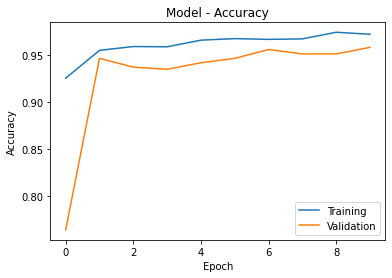

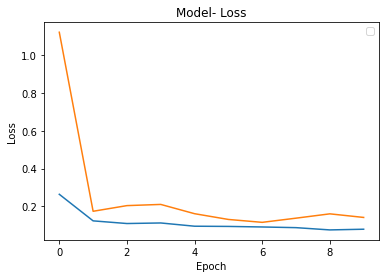

Epoch 1/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0803 - accuracy: 0.9707 - val_loss: 0.1073 - val_accuracy: 0.9626
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0705 - accuracy: 0.9740 - val_loss: 0.1349 - val_accuracy: 0.9556
Epoch 3/10
58/58 [==============================] - 1s 21ms/step - loss: 0.0691 - accuracy: 0.9753 - val_loss: 0.1798 - val_accuracy: 0.9393
Epoch 4/10
58/58 [==============================] - 1s 21ms/step - loss: 0.0662 - accuracy: 0.9726 - val_loss: 0.1366 - val_accuracy: 0.9579
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0828 - accuracy: 0.9691 - val_loss: 0.1485 - val_accuracy: 0.9509
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0817 - accuracy: 0.9694 - val_loss: 0.1076 - val_accuracy: 0.9650
Epoch 7/10
58/58 [==============================] - 1s 21ms/step - loss: 0.0738 - accuracy: 0.9702 - val_loss: 0.1405 - val_accuracy: 0.9579
Epoch 8/10
58

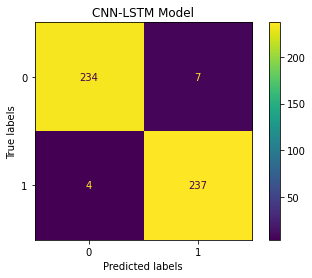

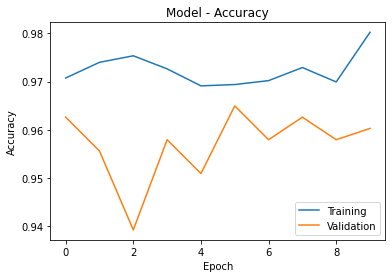

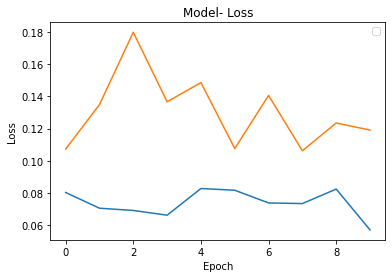

Epoch 1/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0532 - accuracy: 0.9797 - val_loss: 0.1325 - val_accuracy: 0.9556
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0668 - accuracy: 0.9729 - val_loss: 0.1579 - val_accuracy: 0.9393
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0640 - accuracy: 0.9759 - val_loss: 0.1603 - val_accuracy: 0.9556
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0696 - accuracy: 0.9743 - val_loss: 0.1223 - val_accuracy: 0.9533
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0645 - accuracy: 0.9775 - val_loss: 0.0958 - val_accuracy: 0.9626
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0604 - accuracy: 0.9772 - val_loss: 0.1100 - val_accuracy: 0.9650
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0639 - accuracy: 0.9756 - val_loss: 0.0906 - val_accuracy: 0.9743
Epoch 8/10
58

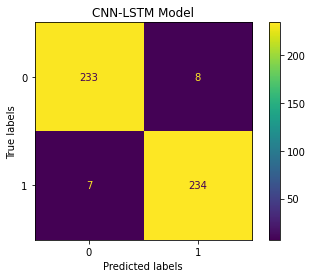

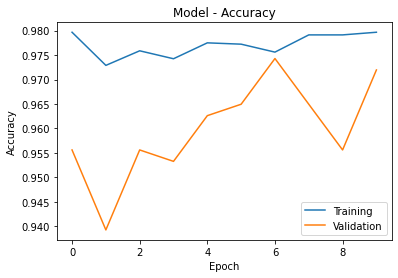

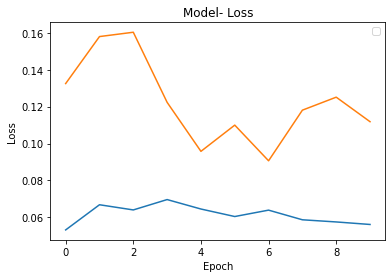

Epoch 1/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0532 - accuracy: 0.9797 - val_loss: 0.1346 - val_accuracy: 0.9486
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0619 - accuracy: 0.9743 - val_loss: 0.0996 - val_accuracy: 0.9673
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0496 - accuracy: 0.9829 - val_loss: 0.2012 - val_accuracy: 0.9369
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0595 - accuracy: 0.9797 - val_loss: 0.1049 - val_accuracy: 0.9696
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0662 - accuracy: 0.9753 - val_loss: 0.1736 - val_accuracy: 0.9486
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0602 - accuracy: 0.9808 - val_loss: 0.1085 - val_accuracy: 0.9696
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0520 - accuracy: 0.9805 - val_loss: 0.1141 - val_accuracy: 0.9696
Epoch 8/10
58

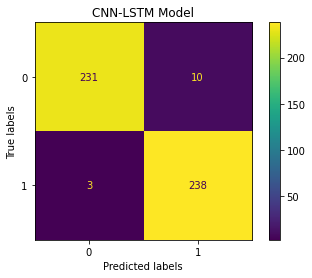

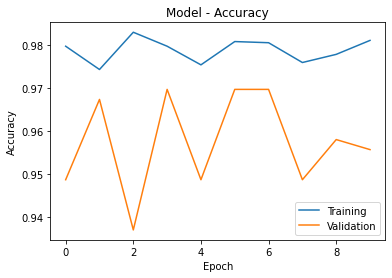

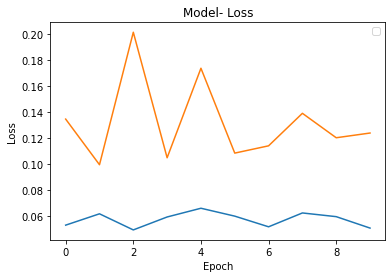

Epoch 1/10
58/58 [==============================] - 2s 26ms/step - loss: 0.0525 - accuracy: 0.9802 - val_loss: 0.1380 - val_accuracy: 0.9603
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0461 - accuracy: 0.9840 - val_loss: 0.1525 - val_accuracy: 0.9603
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0601 - accuracy: 0.9764 - val_loss: 0.1434 - val_accuracy: 0.9463
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0449 - accuracy: 0.9840 - val_loss: 0.1106 - val_accuracy: 0.9556
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0472 - accuracy: 0.9846 - val_loss: 0.1102 - val_accuracy: 0.9696
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0412 - accuracy: 0.9846 - val_loss: 0.1253 - val_accuracy: 0.9603
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0423 - accuracy: 0.9867 - val_loss: 0.1074 - val_accuracy: 0.9673
Epoch 8/10
58

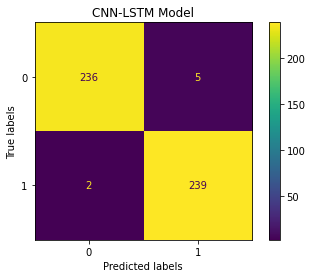

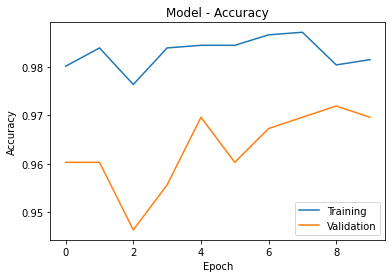

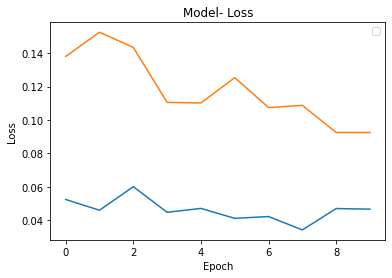

Epoch 1/10
58/58 [==============================] - 2s 26ms/step - loss: 0.0343 - accuracy: 0.9883 - val_loss: 0.1257 - val_accuracy: 0.9626
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0363 - accuracy: 0.9862 - val_loss: 0.1235 - val_accuracy: 0.9603
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0388 - accuracy: 0.9851 - val_loss: 0.1533 - val_accuracy: 0.9509
Epoch 4/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0459 - accuracy: 0.9824 - val_loss: 0.1175 - val_accuracy: 0.9650
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0435 - accuracy: 0.9829 - val_loss: 0.2078 - val_accuracy: 0.9463
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0442 - accuracy: 0.9837 - val_loss: 0.0997 - val_accuracy: 0.9650
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0539 - accuracy: 0.9791 - val_loss: 0.1475 - val_accuracy: 0.9463
Epoch 8/10
58

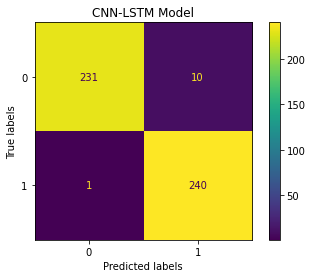

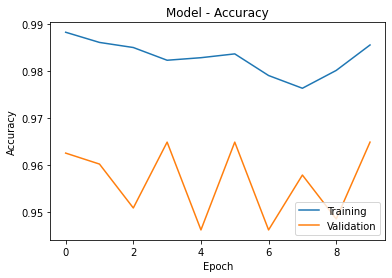

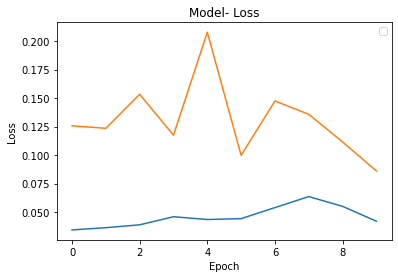

Epoch 1/10
58/58 [==============================] - 1s 24ms/step - loss: 0.0406 - accuracy: 0.9859 - val_loss: 0.1187 - val_accuracy: 0.9579
Epoch 2/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0388 - accuracy: 0.9862 - val_loss: 0.0939 - val_accuracy: 0.9696
Epoch 3/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0401 - accuracy: 0.9851 - val_loss: 0.1082 - val_accuracy: 0.9673
Epoch 4/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0356 - accuracy: 0.9862 - val_loss: 0.1180 - val_accuracy: 0.9603
Epoch 5/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0415 - accuracy: 0.9867 - val_loss: 0.1176 - val_accuracy: 0.9626
Epoch 6/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0386 - accuracy: 0.9867 - val_loss: 0.1064 - val_accuracy: 0.9696
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0376 - accuracy: 0.9859 - val_loss: 0.1181 - val_accuracy: 0.9650
Epoch 8/10
58

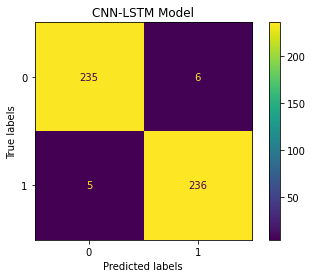

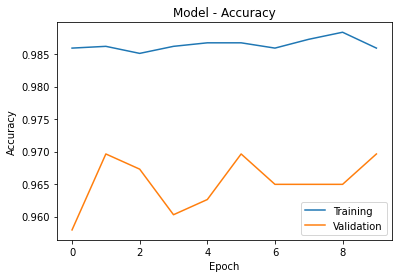

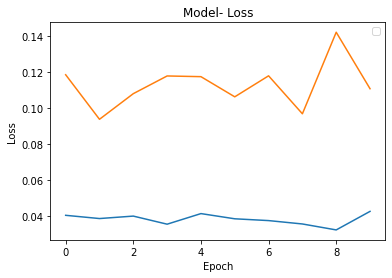

Epoch 1/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0453 - accuracy: 0.9808 - val_loss: 0.1111 - val_accuracy: 0.9626
Epoch 2/10
58/58 [==============================] - 2s 32ms/step - loss: 0.0361 - accuracy: 0.9867 - val_loss: 0.1757 - val_accuracy: 0.9509
Epoch 3/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0351 - accuracy: 0.9875 - val_loss: 0.1446 - val_accuracy: 0.9673
Epoch 4/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0287 - accuracy: 0.9900 - val_loss: 0.1142 - val_accuracy: 0.9673
Epoch 5/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0265 - accuracy: 0.9908 - val_loss: 0.1384 - val_accuracy: 0.9673
Epoch 6/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0490 - accuracy: 0.9805 - val_loss: 0.1155 - val_accuracy: 0.9743
Epoch 7/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0280 - accuracy: 0.9897 - val_loss: 0.1087 - val_accuracy: 0.9743
Epoch 8/10
58

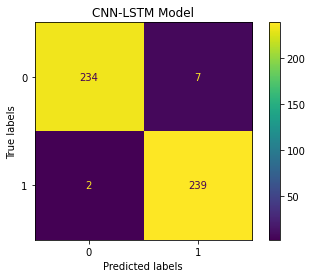

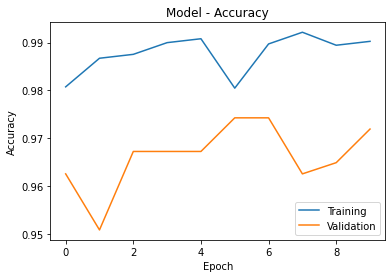

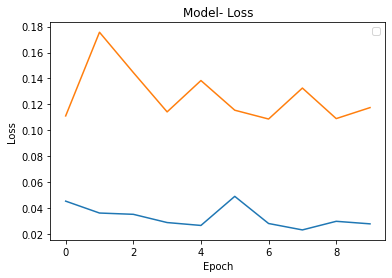

Epoch 1/10
58/58 [==============================] - 2s 27ms/step - loss: 0.0259 - accuracy: 0.9905 - val_loss: 0.1101 - val_accuracy: 0.9766
Epoch 2/10
58/58 [==============================] - 1s 24ms/step - loss: 0.0304 - accuracy: 0.9894 - val_loss: 0.1342 - val_accuracy: 0.9696
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0643 - accuracy: 0.9783 - val_loss: 0.1591 - val_accuracy: 0.9533
Epoch 4/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0332 - accuracy: 0.9886 - val_loss: 0.0993 - val_accuracy: 0.9696
Epoch 5/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0261 - accuracy: 0.9889 - val_loss: 0.1203 - val_accuracy: 0.9673
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0283 - accuracy: 0.9889 - val_loss: 0.1320 - val_accuracy: 0.9650
Epoch 7/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0223 - accuracy: 0.9911 - val_loss: 0.1230 - val_accuracy: 0.9650
Epoch 8/10
58

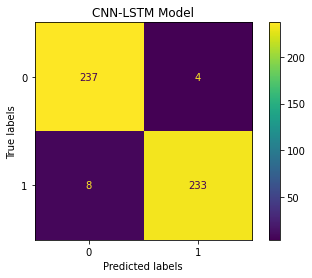

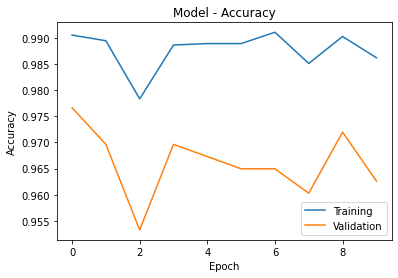

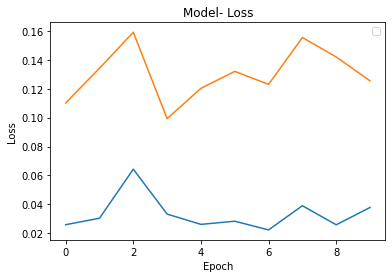

Epoch 1/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0317 - accuracy: 0.9864 - val_loss: 0.1227 - val_accuracy: 0.9556
Epoch 2/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0301 - accuracy: 0.9870 - val_loss: 0.1249 - val_accuracy: 0.9673
Epoch 3/10
58/58 [==============================] - 1s 24ms/step - loss: 0.0353 - accuracy: 0.9875 - val_loss: 0.1610 - val_accuracy: 0.9533
Epoch 4/10
58/58 [==============================] - 1s 24ms/step - loss: 0.0244 - accuracy: 0.9897 - val_loss: 0.1066 - val_accuracy: 0.9720
Epoch 5/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0256 - accuracy: 0.9921 - val_loss: 0.1127 - val_accuracy: 0.9626
Epoch 6/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0219 - accuracy: 0.9916 - val_loss: 0.1042 - val_accuracy: 0.9650
Epoch 7/10
58/58 [==============================] - 1s 23ms/step - loss: 0.0244 - accuracy: 0.9913 - val_loss: 0.1196 - val_accuracy: 0.9626
Epoch 8/10
58

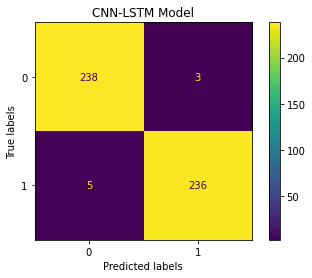

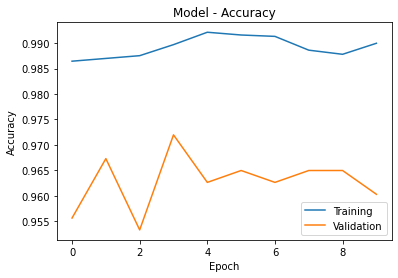

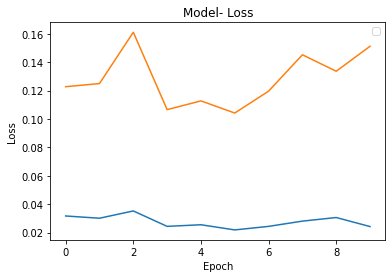

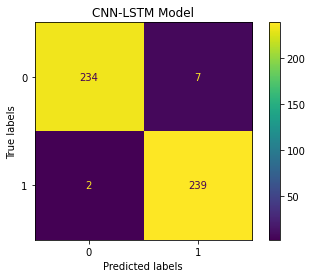

In [ ]:
# fit the model and output accuracies

accuracies_ten = [0] * 10 # cv b preallocate
for t in range(10):
  # train
  history = model_cnn_lstm.fit(X_train_ten[t,:,:],y_train_ten[t],epochs=10, batch_size=64,validation_data=(X_val_ten[t,:,:],y_val_ten[t]))
  
  # evaluate
  evaluate_model(history, X_test_ten[t], y_test_ten[t], model_cnn_lstm)
  y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_ten[t])
  
  # display confusion matrix
  y_pred_cnn_lstm = np.argmax(y_pred_cnn_lstm,axis=1)
  CM_cnn_lstm = confusion_matrix(y_test_ten[t], y_pred_cnn_lstm)
  disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm) 
  disp.plot()
  plt.title('CNN-LSTM Model')
  plt.ylabel('True labels');
  plt.xlabel('Predicted labels');

  # output accuracy
  scores = model_cnn_lstm.evaluate((X_test_ten[t]),y_test_ten[t], verbose=0)
  acc_10 = scores[1]
  accuracies_ten[t] = round(acc_10,3)

In [ ]:
# compute mean and variance of accuracies
print(accuracies_ten)
print(np.mean(accuracies_ten))
print(np.std(accuracies_ten))

[0.977, 0.969, 0.973, 0.985, 0.977, 0.977, 0.981, 0.975, 0.983, 0.981]
0.9778
0.004578209256903843


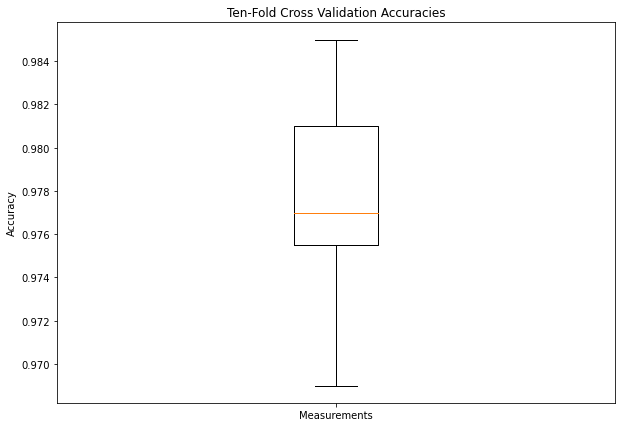

In [ ]:
# plot distribution of accuracies using a boxplot

# fig params
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot(accuracies_ten)

# axis labels
ax.set_xticklabels(['Measurements'])
ax.set_ylabel('Accuracy')
plt.title('Ten-Fold Cross Validation Accuracies')

plt.show(bp)

#### Balanced Binary Classification Summary

The accuracies resulting from balanced binary classification are unexpectedly high. This may be due to the nature of the dataset. 

Nonetheless, from conducting 10-fold cross-validation, we see that performing a balanced binary classification achieves consistent accuracies, ranging from 96% to 99% accuracy with an average at 97%.

# Control Binary Classification Experiment

Because the results of both methods of binary classification resulted in rather high accuracies (94% - 99%), a control experiment is conducted to test the validity of the CNN-LSTM's evaluation ability. 

The epileptic class (class 1) is split into two classes, class 1 and class 0 (dummy class). Our assumption is that if the model is functioning as expected, the model should not be able to distinguish between the two classes. That is, it should not be able to achieve above-chance accuracy which, for binary classification, is 50%.

#### Data Preprocessing

In [ ]:
# re-import the data
data = pd.read_csv('./data.csv', header= None) # load data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# We visualize the dataset
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179
0,NaN,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
1,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
2,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
3,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
4,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5


In [ ]:
# split data into only the epileptic class
data_split = data.loc[data[179].isin([1])]

In [ ]:
# transform the dataset into a numpy array 
data_split = data_split.to_numpy()

# split dataset in features (X) and labels (Y)
X = data_split[1:,1:179]
Y = data_split[1:,-1]

for i in range(0, len(Y)):
    Y[i] = int(Y[i])
print(X.shape,Y.shape)

(1487, 178) (1487,)


In [ ]:
# Change half of the class labels to 0
Y[0:744] = 0

# 80/10/10 Split for both dummy classes
X_train_split0, X_test_split0, y_train_split0, y_test_split0 = train_test_split(X, Y, 
                                                                                test_size=0.1,random_state=1)
X_train_split0, X_val_split0, y_train_split0, y_val_split0 = train_test_split(X_train_split0, y_train_split0, 
                                                                                test_size=0.1,random_state=1)

In [ ]:
# print size with both dummy classes
print('Control Experiment Classification ')
print(X_train_split0.shape, X_val_split0.shape,X_test_split0.shape)
print(y_train_split0.shape, y_val_split0.shape, y_test_split0.shape,'\n')

Control Experiment Classification 
(1204, 178) (134, 178) (149, 178)
(1204,) (134,) (149,) 



In [ ]:
# convert data to tensor to use it in Keras API

X_train_split0 = convert_to_tensor(X_train_split0, dtype=np.float32)
y_train_split0 = convert_to_tensor(y_train_split0,dtype=np.float32)
X_test_split0 = convert_to_tensor(X_test_split0,dtype=np.float32)
y_test_split0 = convert_to_tensor(y_test_split0,dtype=np.float32)
X_val_split0 = convert_to_tensor(X_val_split0,dtype=np.float32)
y_val_split0 = convert_to_tensor(y_val_split0,dtype=np.float32)

#### Model Evaluation

In [ ]:
im_shape=(X_train_split0.shape[1],1)
inputs_cnn_lstm=Input(shape=(im_shape), name='inputs_cnn_lstm')


conv1d_1 = Convolution1D(filters=64, kernel_size=6, activation='relu',padding='valid')(inputs_cnn_lstm)
batch_normalization = BatchNormalization()(conv1d_1) 
max_pooling1d = MaxPool1D(pool_size=92,strides=1, padding='valid')(batch_normalization)
    
conv1d_2 = Convolution1D(filters=128, kernel_size=3, activation='relu',padding='valid')(max_pooling1d)
batch_normalization_1 = BatchNormalization()(conv1d_2) 
max_pooling1d_1 = MaxPool1D(pool_size=45,strides=1, padding='valid')(batch_normalization_1)
    
lstm = LSTM(128)(max_pooling1d_1)

flatten = Flatten()(lstm)
dense = Dense(64, activation='relu')(flatten)
dense_1 = Dense(32, activation='relu')(dense)
main_output = Dense(2, activation='softmax')(dense_1)
  
model = Model(inputs=inputs_cnn_lstm, outputs=main_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model_cnn_lstm_split0 = model
print(model_cnn_lstm.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn_lstm (InputLayer  [(None, 178, 1)]         0         
 )                                                               
                                                                 
 conv1d_13 (Conv1D)          (None, 173, 64)           448       
                                                                 
 batch_normalization_14 (Bat  (None, 173, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 82, 64)           0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 80, 128)           24704     
                                                           

In [ ]:
history=model_cnn_lstm_split0.fit(X_train_split0,y_train_split0,epochs=20, batch_size=64,validation_data=(X_val_split0,y_val_split0))

Epoch 1/20
19/19 [==============================] - 1s 43ms/step - loss: 0.6721 - accuracy: 0.5615 - val_loss: 0.7006 - val_accuracy: 0.4701
Epoch 2/20
19/19 [==============================] - 1s 37ms/step - loss: 0.6708 - accuracy: 0.5540 - val_loss: 0.7232 - val_accuracy: 0.4851
Epoch 3/20
19/19 [==============================] - 1s 35ms/step - loss: 0.6653 - accuracy: 0.5748 - val_loss: 0.7278 - val_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 1s 33ms/step - loss: 0.6697 - accuracy: 0.5731 - val_loss: 0.7139 - val_accuracy: 0.4403
Epoch 5/20
19/19 [==============================] - 1s 33ms/step - loss: 0.6746 - accuracy: 0.5664 - val_loss: 0.7187 - val_accuracy: 0.4478
Epoch 6/20
19/19 [==============================] - 1s 31ms/step - loss: 0.6729 - accuracy: 0.5764 - val_loss: 0.7094 - val_accuracy: 0.5075
Epoch 7/20
19/19 [==============================] - 1s 32ms/step - loss: 0.6751 - accuracy: 0.5764 - val_loss: 0.7107 - val_accuracy: 0.4925
Epoch 8/20
19

Accuracy: 45.64%
Loss: 74.44%


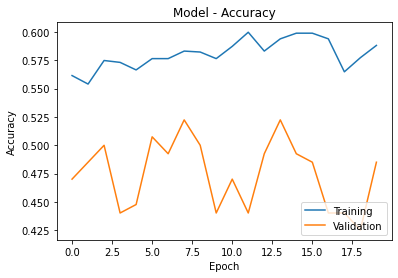

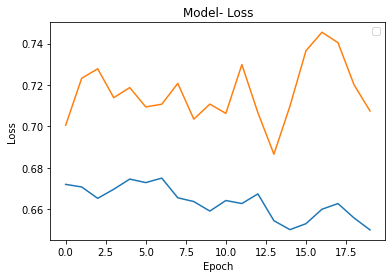

In [ ]:
evaluate_model(history,X_test_split0,y_test_split0,model_cnn_lstm_split0)
y_pred_cnn_lstm_split0 = model_cnn_lstm_split0.predict(X_test_split0)

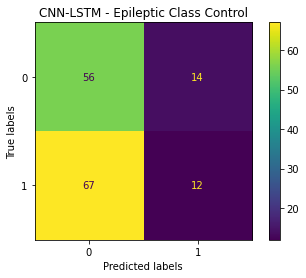

In [ ]:
# confusion matrix
y_pred_cnn_lstm_split0 = np.argmax(y_pred_cnn_lstm_split0,axis=1)

CM_cnn_lstm_split0 = confusion_matrix(y_test_split0, y_pred_cnn_lstm_split0)
disp = ConfusionMatrixDisplay(confusion_matrix=CM_cnn_lstm_split0) 
disp.plot()
plt.title('CNN-LSTM - Epileptic Class Control')
plt.ylabel('True labels');
plt.xlabel('Predicted labels');

#### Control Binary Classification Summary

As anticipated, the model was not able to achieve above-chance accuracy (50%) at only 45.6% accuracy. 

This experiment increases our confidence in the model's binary classification accuracies because if the high accuracies achieved from binary classification were trivial, then our assumption is that this experiment would have also resulted in a trivially high accuracy.

# Epileptic Seizure Classification Summary

The results of classifying epilepsy in EEG data with both multi-class and binary classification methods elucidated a variety of information, some expected and some unexpected.

From multi-class classification, we determined that the CNN-LSTM model was the best fit for this dataset, achieving approximately 75% accuracy. The CNN-LSTM model's success comes from its special architecture; the CNN acts as a (spatial) feature extractor from which the LSTM is able to perform sequence prediction/classification. Although this dataset is provided as single-channel EEG, it is inherently composed of spatiotemporal data by use of a 10-20 EEG cap. From evaluating the multi-class confusion matrices, it is readily apparent that while all four models had the easiest time classifying the epileptic activity of class 1, they struggled, in particular, to distinguish between classes 2 and 3. Therefore, we suspect that because these data are resting-state EEG, it may be the case that classes 2 and 3 are simply from different electrodes. If so, the resting-state EEG may not be significantly different enough to classify between two nearby electrodes, especially if both electrodes contain non-epileptic activity. And although all models struggled with these two classes, this hypothesis is supported by the fact that the CNN-LSTM performed the best, considering its ability to extract spatial features. 

From binary classification, we gained two major insights. First, performing inter-class classification allowed us to confirm our observations from the multi-class classification. In particular, classes 2 and 3 compare almost identically to class 1, strengthening the notion that these classes are marginally dissimilar to each other due to suspected spatial proximity. Furthermore, the accuracy in classification between classes 1 and 4 (eyes closed) is notably the lowest. This could be explained by the presence of alpha waves during recordings when a subject's eyes are closed. Although the presence of a "different" signal would be expected to aid classification, it may instead act as a confound for finding nuanced differences against the epileptic class. This is because epilepsy is characterized by its hypersynchronous nature, which may appear similar to alpha waveforms in the feature space. On the other hand, the last class (eyes open) has the highest accuracy. Coupled with the result of the class 4, this may also indicate that the majority of subjects' eyes were closed during epileptic seizures, but this is a broader assumption.

Then, 10-fold cross-validation was performed on a balanced binary dataset, comparing epileptic activity against the grouped non-epileptic activity. The cross-validation achieves consistent accuracies, ranging from 96% to 99% with an average of 97%. From repeating this classification 10-fold, we confirm that randomly sampling from the non-epileptic data is stable. However, we note that these accuracies were unexpectedly high, suggesting that either epileptic activity is extremely easy to classify or that our CNN-LSTM model was performing a trivial classification. 

To confirm, a control binary classification experiment was conducted in which the epileptic class (class 1) was split into two classes, class 1 and class 0 (dummy class). Reassuringly, the model was not able to achieve above-chance accuracy (50%) at only 45.6% accuracy. Therefore, we can assume with more confidence that epileptic EEG is readily distinguishable from healthy EEG. Furthermore, we solidify the CNN-LSTM as a more than suitable model for performing binary classification on epileptic seizure EEG data.

By exploring four models (CNN, LSTM, CNN-LSTM) on a total of four classification methods (multi-class, inter-class binary, balanced binary, control binary), we conclude that a CNN-LSTM can perform binary classification on epileptic EEG data with high accuracy. Despite this fact, multi-class and inter-class classification allowed us to perceive more nuanced differences between the classes that match our assumptions on the dataset. For future work, it may be interesting to explore the similarities between non-epileptic activity recorded from an epileptogenic zone directly (class 2) and non-epileptic activity recorded from healthy tissue (class 3). The misclassification observed between these classes hints at a potential for epilepsy prediction/epileptogenic zone localization from EEG data.